# Kaggle Titanic competition
goal: create fast and submit to learn how to deal with Kaggle


In [1]:
# general & data analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing imports
from sklearn import preprocessing
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split

# model learning & evaluation imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

## data loading

In [2]:
train_dataset=pd.read_csv('train.csv')
test_dataset=pd.read_csv('test.csv')

## data analysis

In [3]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train_dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_dataset.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


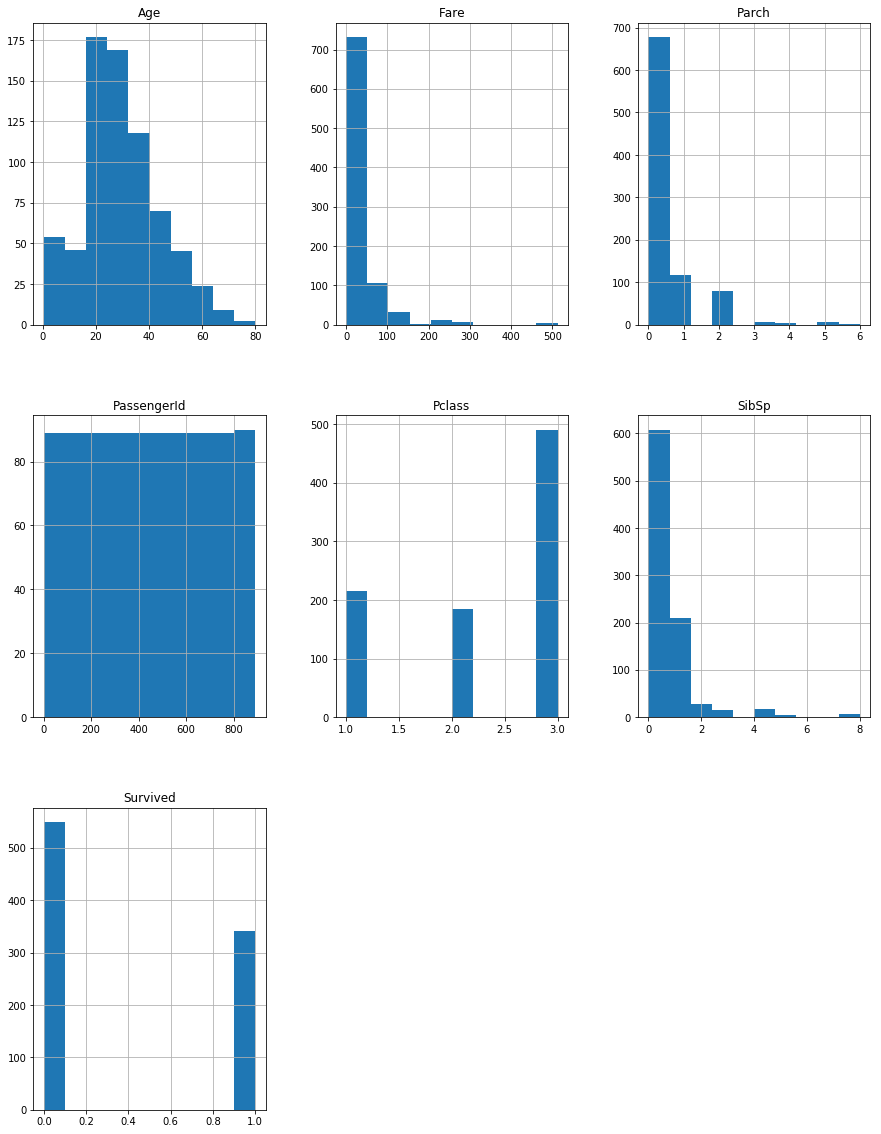

<Figure size 432x288 with 0 Axes>

In [6]:
train_dataset.hist(figsize=(15,20));
plt.figure();

C:\Users\slowito1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\slowito1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\slowito1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\slowito1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\slowito1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid 

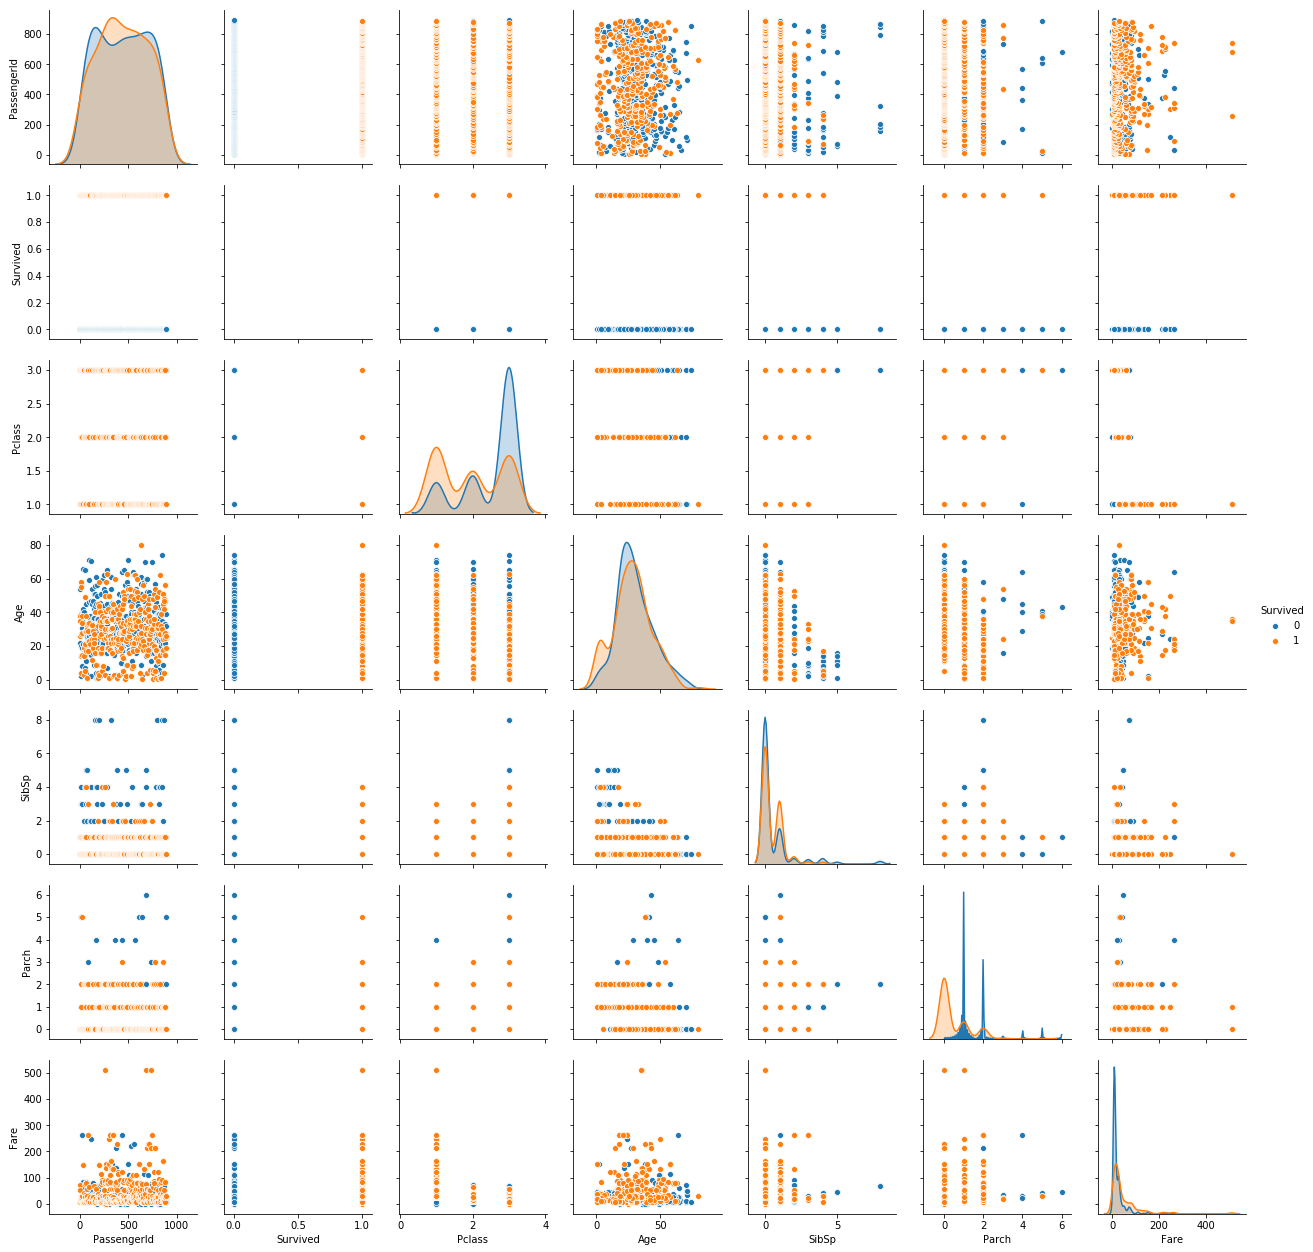

In [7]:
sns.pairplot(train_dataset, hue="Survived");

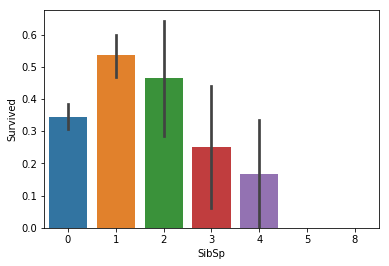

In [8]:
sns.barplot(x="SibSp", y="Survived", data=train_dataset)

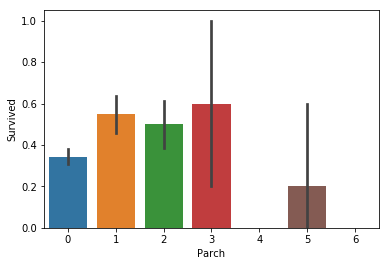

In [9]:
sns.barplot(x="Parch", y="Survived", data=train_dataset)

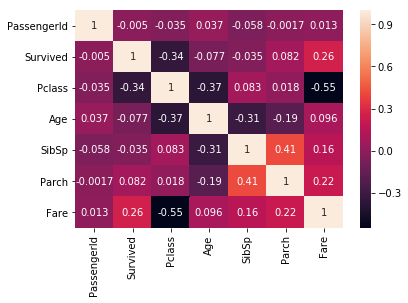

In [10]:
sns.heatmap(train_dataset.corr(),annot=True) 


In [11]:
test_dataset.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## data preprocessing

In [12]:
# remove dependent variable from train set to have the same structure as test set
df_y=train_dataset['Survived'].copy()
train_dataset.drop('Survived', axis=1,inplace=True)

In [13]:
def preprocess_data(source_df):
    df=source_df.copy()
    # Age to bins, NaN to separate bin
    df.Age.fillna(-1, inplace=True)
    age_bins=(-10,0,10,30,500)
    age_labels=('unk','upto10','upto30','above30')
    df.Age=pd.cut(df.Age, age_bins, labels=age_labels)
    #cabin - keep first letter
    df.Cabin.fillna('Unknown', inplace=True)
    df.Cabin=df.Cabin.apply(lambda x: x[0])
    # fare - divide by mean (~32)
    df.Fare.fillna(df.Fare.median(), inplace=True)
    df.Fare=df.Fare.apply(lambda x: x/32)
    # embarked - fillna
    df.Embarked.fillna('U', inplace=True)
    # SibSp, Parch - replace to binary
    df['SibSp']=df['SibSp'].apply(lambda x: 1 if (x==1)|(x==2) else 0)
    df['Parch']=df['Parch'].apply(lambda x: 1 if (x==1)|(x==2)|(x==3) else 0)
    
    #df['FamilySize']=df['SibSp']+df['Parch']+1
    #df.SibSp=df.SibSp.apply(lambda x: int(x>0))
    #df.Parch=df.Parch.apply(lambda x: int(x>0))
    # df['Fam_label']=df.FamilySize.apply(Fam_label)
    # ticket, name - drop
    df=df.drop(['Ticket','Name'], axis=1)

    #return preprocessed df
    return df


In [14]:
df_test=preprocess_data(test_dataset)
df_train=preprocess_data(train_dataset)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null category
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 56.8+ KB


In [16]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,upto30,1,0,0.226562,U,S
1,2,1,female,above30,1,0,2.227603,C,C
2,3,3,female,upto30,0,0,0.247656,U,S
3,4,1,female,above30,1,0,1.659375,C,S
4,5,3,male,above30,0,0,0.251563,U,S


In [17]:
def encode(df1, df2):
    '''df1, df2 - train and test dataframes
    return - modified df1, df2'''
    
    cat_features =['Sex','Pclass'] # features for categorization
    onehot_features=['Cabin','Embarked','Age'] # features for onehot encoding
    
    # for each feature, use LabelEncoder on both dataframes
    for f in cat_features:
        l_encoder = preprocessing.LabelEncoder()
        l_encoder.fit(df1[f])
        df1[f]=l_encoder.transform(df1[f])
        df2[f]=l_encoder.transform(df2[f])

    # use OneHotEncoder on both dataframes
    oh_encoder = ce.OneHotEncoder(handle_unknown='ignore', cols=onehot_features,use_cat_names=True)
    df1=oh_encoder.fit_transform(df1)
    df2=oh_encoder.transform(df2)
    
    #drop manually featurez for "unknown" values
    df1.drop('Age_unk', axis=1, inplace=True)
    df2.drop('Age_unk', axis=1, inplace=True)
    df1.drop('Embarked_U', axis=1, inplace=True)
    df2.drop('Embarked_U', axis=1, inplace=True)

    return df1,df2
        
    

In [18]:
df_train, df_test = encode(df_train, df_test)

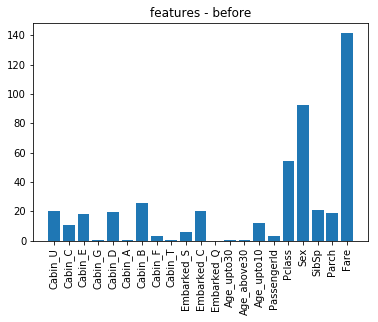

selected: ['Cabin_U', 'Cabin_E', 'Cabin_D', 'Cabin_B', 'Embarked_S', 'Embarked_C', 'Age_upto10', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
removed: ['Cabin_C', 'Cabin_G', 'Cabin_A', 'Cabin_F', 'Cabin_T', 'Embarked_Q', 'Age_upto30', 'Age_above30', 'PassengerId']


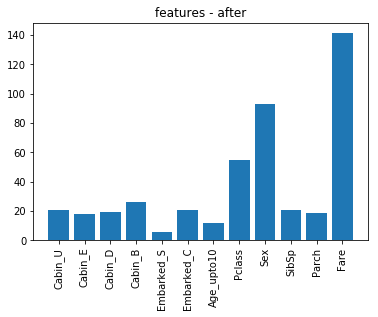

In [19]:
# Perform feature selection
K=12

#draw a graph before
predictors=df_train.columns.tolist()
#selector = SelectKBest(f_classif, k='all')
selector = SelectKBest(chi2, k='all')
_=selector.fit(df_train, df_y)
plt.bar(range(len(predictors)), selector.scores_)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.title('features - before')
plt.show()

# select K best features

selector = SelectKBest(f_classif, k=K)
X_train_pruned=selector.fit_transform(df_train, df_y)
X_test_pruned=selector.transform(df_test)  

selected_features=df_train.columns[selector.get_support(indices=True)].tolist()
removed_features=[x for x in predictors if x not in selected_features]
print(f'selected: {selected_features}')
print(f'removed: {removed_features}')

#draw a graph after
selector = SelectKBest(chi2, k='all')
_=selector.fit(X_train_pruned, df_y)
plt.bar(range(len(selected_features)), selector.scores_)
plt.xticks(range(len(selected_features)), selected_features, rotation='vertical')
plt.title('features - after')
plt.show()


In [20]:
X_train_pruned.shape

(891, 12)

## building MLP model

In [21]:
# split train and validation
# X_train,X_val,y_train,y_val=train_test_split(df_train.values,dfy.values,test_size=0.25,random_state=1, shuffle=True)
X_train,X_val,y_train,y_val=train_test_split(X_train_pruned,df_y.values,test_size=0.25,random_state=1, shuffle=True)
X_test=X_test_pruned

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(668, 12)
(668,)
(223, 12)
(223,)
(418, 12)


In [23]:
def mlp_model(units_list, l2=0, dropout_rate=0):
    model=models.Sequential()
    for u in units_list:
        model.add(Dense(units=u, activation='relu',kernel_regularizer=regularizers.l2(l2)))
        if dropout_rate>0:
            model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [24]:
def train_model(model,data,epochs=20,learning_rate=1e-3):
    
    X_train, y_train, X_val, y_val = data
    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in <patience> consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20)]

    # Train and validate model.
    history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
    #        callbacks=callbacks,
            validation_data=(X_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=128)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Plot training & validation accuracy values
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Save model.
    # model.save('titanic.h5')
    return history['val_acc'][-1], history['val_loss'][-1], model

In [25]:
my_model=mlp_model(units_list=[8,8,6],l2=0.005,dropout_rate=0)

Train on 668 samples, validate on 223 samples
Epoch 1/1000
 - 1s - loss: 0.9984 - acc: 0.3698 - val_loss: 0.9338 - val_acc: 0.4260
Epoch 2/1000
 - 0s - loss: 0.9632 - acc: 0.3698 - val_loss: 0.9060 - val_acc: 0.4260
Epoch 3/1000
 - 0s - loss: 0.9313 - acc: 0.3698 - val_loss: 0.8827 - val_acc: 0.4215
Epoch 4/1000
 - 0s - loss: 0.9033 - acc: 0.3683 - val_loss: 0.8630 - val_acc: 0.4170
Epoch 5/1000
 - 0s - loss: 0.8811 - acc: 0.3668 - val_loss: 0.8462 - val_acc: 0.4170
Epoch 6/1000
 - 0s - loss: 0.8611 - acc: 0.3668 - val_loss: 0.8324 - val_acc: 0.4215
Epoch 7/1000
 - 0s - loss: 0.8446 - acc: 0.3668 - val_loss: 0.8205 - val_acc: 0.4170
Epoch 8/1000
 - 0s - loss: 0.8301 - acc: 0.3683 - val_loss: 0.8104 - val_acc: 0.4215
Epoch 9/1000
 - 0s - loss: 0.8180 - acc: 0.3713 - val_loss: 0.8016 - val_acc: 0.4170
Epoch 10/1000
 - 0s - loss: 0.8068 - acc: 0.3802 - val_loss: 0.7941 - val_acc: 0.4305
Epoch 11/1000
 - 0s - loss: 0.7974 - acc: 0.3967 - val_loss: 0.7874 - val_acc: 0.4350
Epoch 12/1000
 - 

Epoch 96/1000
 - 0s - loss: 0.4710 - acc: 0.8293 - val_loss: 0.5597 - val_acc: 0.7713
Epoch 97/1000
 - 0s - loss: 0.4702 - acc: 0.8293 - val_loss: 0.5598 - val_acc: 0.7713
Epoch 98/1000
 - 0s - loss: 0.4697 - acc: 0.8353 - val_loss: 0.5608 - val_acc: 0.7668
Epoch 99/1000
 - 0s - loss: 0.4689 - acc: 0.8204 - val_loss: 0.5611 - val_acc: 0.7848
Epoch 100/1000
 - 0s - loss: 0.4682 - acc: 0.8308 - val_loss: 0.5606 - val_acc: 0.7803
Epoch 101/1000
 - 0s - loss: 0.4678 - acc: 0.8308 - val_loss: 0.5600 - val_acc: 0.7713
Epoch 102/1000
 - 0s - loss: 0.4674 - acc: 0.8323 - val_loss: 0.5601 - val_acc: 0.7758
Epoch 103/1000
 - 0s - loss: 0.4665 - acc: 0.8263 - val_loss: 0.5608 - val_acc: 0.7668
Epoch 104/1000
 - 0s - loss: 0.4660 - acc: 0.8278 - val_loss: 0.5603 - val_acc: 0.7848
Epoch 105/1000
 - 0s - loss: 0.4655 - acc: 0.8189 - val_loss: 0.5612 - val_acc: 0.7803
Epoch 106/1000
 - 0s - loss: 0.4650 - acc: 0.8323 - val_loss: 0.5601 - val_acc: 0.7803
Epoch 107/1000
 - 0s - loss: 0.4640 - acc: 0.83

Epoch 191/1000
 - 0s - loss: 0.4407 - acc: 0.8428 - val_loss: 0.5520 - val_acc: 0.7892
Epoch 192/1000
 - 0s - loss: 0.4410 - acc: 0.8488 - val_loss: 0.5499 - val_acc: 0.7848
Epoch 193/1000
 - 0s - loss: 0.4418 - acc: 0.8503 - val_loss: 0.5505 - val_acc: 0.7848
Epoch 194/1000
 - 0s - loss: 0.4412 - acc: 0.8503 - val_loss: 0.5554 - val_acc: 0.7937
Epoch 195/1000
 - 0s - loss: 0.4412 - acc: 0.8398 - val_loss: 0.5541 - val_acc: 0.7937
Epoch 196/1000
 - 0s - loss: 0.4394 - acc: 0.8503 - val_loss: 0.5488 - val_acc: 0.7803
Epoch 197/1000
 - 0s - loss: 0.4427 - acc: 0.8503 - val_loss: 0.5489 - val_acc: 0.7848
Epoch 198/1000
 - 0s - loss: 0.4406 - acc: 0.8503 - val_loss: 0.5534 - val_acc: 0.7892
Epoch 199/1000
 - 0s - loss: 0.4412 - acc: 0.8413 - val_loss: 0.5598 - val_acc: 0.7937
Epoch 200/1000
 - 0s - loss: 0.4415 - acc: 0.8398 - val_loss: 0.5568 - val_acc: 0.7937
Epoch 201/1000
 - 0s - loss: 0.4405 - acc: 0.8458 - val_loss: 0.5503 - val_acc: 0.7803
Epoch 202/1000
 - 0s - loss: 0.4411 - acc: 

Epoch 286/1000
 - 0s - loss: 0.4270 - acc: 0.8503 - val_loss: 0.5432 - val_acc: 0.7848
Epoch 287/1000
 - 0s - loss: 0.4272 - acc: 0.8503 - val_loss: 0.5438 - val_acc: 0.7848
Epoch 288/1000
 - 0s - loss: 0.4269 - acc: 0.8473 - val_loss: 0.5467 - val_acc: 0.7892
Epoch 289/1000
 - 0s - loss: 0.4272 - acc: 0.8503 - val_loss: 0.5415 - val_acc: 0.7848
Epoch 290/1000
 - 0s - loss: 0.4270 - acc: 0.8518 - val_loss: 0.5412 - val_acc: 0.7848
Epoch 291/1000
 - 0s - loss: 0.4265 - acc: 0.8503 - val_loss: 0.5429 - val_acc: 0.7892
Epoch 292/1000
 - 0s - loss: 0.4258 - acc: 0.8488 - val_loss: 0.5471 - val_acc: 0.7892
Epoch 293/1000
 - 0s - loss: 0.4285 - acc: 0.8488 - val_loss: 0.5494 - val_acc: 0.7892
Epoch 294/1000
 - 0s - loss: 0.4251 - acc: 0.8503 - val_loss: 0.5409 - val_acc: 0.7848
Epoch 295/1000
 - 0s - loss: 0.4274 - acc: 0.8548 - val_loss: 0.5410 - val_acc: 0.7848
Epoch 296/1000
 - 0s - loss: 0.4270 - acc: 0.8563 - val_loss: 0.5446 - val_acc: 0.7848
Epoch 297/1000
 - 0s - loss: 0.4256 - acc: 

 - 0s - loss: 0.4186 - acc: 0.8533 - val_loss: 0.5450 - val_acc: 0.7892
Epoch 381/1000
 - 0s - loss: 0.4181 - acc: 0.8563 - val_loss: 0.5459 - val_acc: 0.7892
Epoch 382/1000
 - 0s - loss: 0.4177 - acc: 0.8563 - val_loss: 0.5419 - val_acc: 0.7892
Epoch 383/1000
 - 0s - loss: 0.4181 - acc: 0.8548 - val_loss: 0.5416 - val_acc: 0.7892
Epoch 384/1000
 - 0s - loss: 0.4179 - acc: 0.8548 - val_loss: 0.5423 - val_acc: 0.7892
Epoch 385/1000
 - 0s - loss: 0.4174 - acc: 0.8593 - val_loss: 0.5454 - val_acc: 0.7982
Epoch 386/1000
 - 0s - loss: 0.4178 - acc: 0.8563 - val_loss: 0.5422 - val_acc: 0.7937
Epoch 387/1000
 - 0s - loss: 0.4171 - acc: 0.8563 - val_loss: 0.5404 - val_acc: 0.7892
Epoch 388/1000
 - 0s - loss: 0.4182 - acc: 0.8578 - val_loss: 0.5439 - val_acc: 0.7937
Epoch 389/1000
 - 0s - loss: 0.4175 - acc: 0.8608 - val_loss: 0.5442 - val_acc: 0.7937
Epoch 390/1000
 - 0s - loss: 0.4170 - acc: 0.8593 - val_loss: 0.5421 - val_acc: 0.7892
Epoch 391/1000
 - 0s - loss: 0.4178 - acc: 0.8578 - val_lo

Epoch 475/1000
 - 0s - loss: 0.4119 - acc: 0.8593 - val_loss: 0.5461 - val_acc: 0.7982
Epoch 476/1000
 - 0s - loss: 0.4117 - acc: 0.8608 - val_loss: 0.5474 - val_acc: 0.7982
Epoch 477/1000
 - 0s - loss: 0.4113 - acc: 0.8548 - val_loss: 0.5416 - val_acc: 0.7892
Epoch 478/1000
 - 0s - loss: 0.4107 - acc: 0.8533 - val_loss: 0.5412 - val_acc: 0.7892
Epoch 479/1000
 - 0s - loss: 0.4109 - acc: 0.8548 - val_loss: 0.5416 - val_acc: 0.7937
Epoch 480/1000
 - 0s - loss: 0.4119 - acc: 0.8563 - val_loss: 0.5435 - val_acc: 0.7982
Epoch 481/1000
 - 0s - loss: 0.4105 - acc: 0.8593 - val_loss: 0.5376 - val_acc: 0.7937
Epoch 482/1000
 - 0s - loss: 0.4104 - acc: 0.8593 - val_loss: 0.5406 - val_acc: 0.7937
Epoch 483/1000
 - 0s - loss: 0.4101 - acc: 0.8578 - val_loss: 0.5453 - val_acc: 0.7937
Epoch 484/1000
 - 0s - loss: 0.4108 - acc: 0.8563 - val_loss: 0.5438 - val_acc: 0.7937
Epoch 485/1000
 - 0s - loss: 0.4115 - acc: 0.8608 - val_loss: 0.5397 - val_acc: 0.7892
Epoch 486/1000
 - 0s - loss: 0.4116 - acc: 

Epoch 570/1000
 - 0s - loss: 0.4059 - acc: 0.8638 - val_loss: 0.5399 - val_acc: 0.7892
Epoch 571/1000
 - 0s - loss: 0.4046 - acc: 0.8653 - val_loss: 0.5476 - val_acc: 0.7937
Epoch 572/1000
 - 0s - loss: 0.4082 - acc: 0.8623 - val_loss: 0.5535 - val_acc: 0.7937
Epoch 573/1000
 - 0s - loss: 0.4084 - acc: 0.8638 - val_loss: 0.5491 - val_acc: 0.7937
Epoch 574/1000
 - 0s - loss: 0.4058 - acc: 0.8638 - val_loss: 0.5407 - val_acc: 0.7892
Epoch 575/1000
 - 0s - loss: 0.4061 - acc: 0.8623 - val_loss: 0.5399 - val_acc: 0.7892
Epoch 576/1000
 - 0s - loss: 0.4053 - acc: 0.8623 - val_loss: 0.5442 - val_acc: 0.7937
Epoch 577/1000
 - 0s - loss: 0.4051 - acc: 0.8653 - val_loss: 0.5471 - val_acc: 0.7937
Epoch 578/1000
 - 0s - loss: 0.4049 - acc: 0.8653 - val_loss: 0.5454 - val_acc: 0.7937
Epoch 579/1000
 - 0s - loss: 0.4043 - acc: 0.8638 - val_loss: 0.5442 - val_acc: 0.7937
Epoch 580/1000
 - 0s - loss: 0.4043 - acc: 0.8623 - val_loss: 0.5404 - val_acc: 0.7892
Epoch 581/1000
 - 0s - loss: 0.4045 - acc: 

Epoch 665/1000
 - 0s - loss: 0.3998 - acc: 0.8668 - val_loss: 0.5507 - val_acc: 0.7982
Epoch 666/1000
 - 0s - loss: 0.4004 - acc: 0.8653 - val_loss: 0.5460 - val_acc: 0.7937
Epoch 667/1000
 - 0s - loss: 0.3990 - acc: 0.8638 - val_loss: 0.5405 - val_acc: 0.7892
Epoch 668/1000
 - 0s - loss: 0.3999 - acc: 0.8683 - val_loss: 0.5406 - val_acc: 0.7892
Epoch 669/1000
 - 0s - loss: 0.3987 - acc: 0.8638 - val_loss: 0.5484 - val_acc: 0.7982
Epoch 670/1000
 - 0s - loss: 0.3999 - acc: 0.8638 - val_loss: 0.5431 - val_acc: 0.7937
Epoch 671/1000
 - 0s - loss: 0.3993 - acc: 0.8683 - val_loss: 0.5396 - val_acc: 0.7848
Epoch 672/1000
 - 0s - loss: 0.4014 - acc: 0.8698 - val_loss: 0.5396 - val_acc: 0.7848
Epoch 673/1000
 - 0s - loss: 0.3990 - acc: 0.8683 - val_loss: 0.5492 - val_acc: 0.7937
Epoch 674/1000
 - 0s - loss: 0.4005 - acc: 0.8608 - val_loss: 0.5519 - val_acc: 0.7937
Epoch 675/1000
 - 0s - loss: 0.4016 - acc: 0.8653 - val_loss: 0.5479 - val_acc: 0.7982
Epoch 676/1000
 - 0s - loss: 0.4005 - acc: 

Epoch 760/1000
 - 0s - loss: 0.3962 - acc: 0.8683 - val_loss: 0.5456 - val_acc: 0.7848
Epoch 761/1000
 - 0s - loss: 0.3956 - acc: 0.8653 - val_loss: 0.5448 - val_acc: 0.7848
Epoch 762/1000
 - 0s - loss: 0.3972 - acc: 0.8668 - val_loss: 0.5498 - val_acc: 0.7937
Epoch 763/1000
 - 0s - loss: 0.3957 - acc: 0.8698 - val_loss: 0.5444 - val_acc: 0.7848
Epoch 764/1000
 - 0s - loss: 0.3952 - acc: 0.8668 - val_loss: 0.5436 - val_acc: 0.7848
Epoch 765/1000
 - 0s - loss: 0.3949 - acc: 0.8668 - val_loss: 0.5468 - val_acc: 0.7848
Epoch 766/1000
 - 0s - loss: 0.3956 - acc: 0.8683 - val_loss: 0.5419 - val_acc: 0.7892
Epoch 767/1000
 - 0s - loss: 0.3957 - acc: 0.8713 - val_loss: 0.5388 - val_acc: 0.7892
Epoch 768/1000
 - 0s - loss: 0.3961 - acc: 0.8728 - val_loss: 0.5406 - val_acc: 0.7892
Epoch 769/1000
 - 0s - loss: 0.3955 - acc: 0.8713 - val_loss: 0.5431 - val_acc: 0.7937
Epoch 770/1000
 - 0s - loss: 0.3948 - acc: 0.8713 - val_loss: 0.5460 - val_acc: 0.7937
Epoch 771/1000
 - 0s - loss: 0.3963 - acc: 

 - 0s - loss: 0.3922 - acc: 0.8653 - val_loss: 0.5478 - val_acc: 0.7892
Epoch 855/1000
 - 0s - loss: 0.3919 - acc: 0.8698 - val_loss: 0.5466 - val_acc: 0.7892
Epoch 856/1000
 - 0s - loss: 0.3919 - acc: 0.8698 - val_loss: 0.5502 - val_acc: 0.7937
Epoch 857/1000
 - 0s - loss: 0.3935 - acc: 0.8683 - val_loss: 0.5541 - val_acc: 0.7892
Epoch 858/1000
 - 0s - loss: 0.3923 - acc: 0.8668 - val_loss: 0.5446 - val_acc: 0.7848
Epoch 859/1000
 - 0s - loss: 0.3930 - acc: 0.8713 - val_loss: 0.5439 - val_acc: 0.7848
Epoch 860/1000
 - 0s - loss: 0.3918 - acc: 0.8698 - val_loss: 0.5485 - val_acc: 0.7892
Epoch 861/1000
 - 0s - loss: 0.3922 - acc: 0.8683 - val_loss: 0.5463 - val_acc: 0.7892
Epoch 862/1000
 - 0s - loss: 0.3931 - acc: 0.8683 - val_loss: 0.5414 - val_acc: 0.7803
Epoch 863/1000
 - 0s - loss: 0.3917 - acc: 0.8698 - val_loss: 0.5516 - val_acc: 0.7937
Epoch 864/1000
 - 0s - loss: 0.3927 - acc: 0.8653 - val_loss: 0.5478 - val_acc: 0.7937
Epoch 865/1000
 - 0s - loss: 0.3912 - acc: 0.8698 - val_lo

Epoch 949/1000
 - 0s - loss: 0.3894 - acc: 0.8668 - val_loss: 0.5455 - val_acc: 0.7937
Epoch 950/1000
 - 0s - loss: 0.3884 - acc: 0.8698 - val_loss: 0.5405 - val_acc: 0.7848
Epoch 951/1000
 - 0s - loss: 0.3883 - acc: 0.8713 - val_loss: 0.5408 - val_acc: 0.7848
Epoch 952/1000
 - 0s - loss: 0.3883 - acc: 0.8713 - val_loss: 0.5451 - val_acc: 0.7848
Epoch 953/1000
 - 0s - loss: 0.3879 - acc: 0.8698 - val_loss: 0.5483 - val_acc: 0.7848
Epoch 954/1000
 - 0s - loss: 0.3885 - acc: 0.8728 - val_loss: 0.5497 - val_acc: 0.7848
Epoch 955/1000
 - 0s - loss: 0.3884 - acc: 0.8728 - val_loss: 0.5473 - val_acc: 0.7803
Epoch 956/1000
 - 0s - loss: 0.3880 - acc: 0.8683 - val_loss: 0.5416 - val_acc: 0.7848
Epoch 957/1000
 - 0s - loss: 0.3879 - acc: 0.8698 - val_loss: 0.5441 - val_acc: 0.7803
Epoch 958/1000
 - 0s - loss: 0.3878 - acc: 0.8698 - val_loss: 0.5430 - val_acc: 0.7848
Epoch 959/1000
 - 0s - loss: 0.3880 - acc: 0.8683 - val_loss: 0.5408 - val_acc: 0.7848
Epoch 960/1000
 - 0s - loss: 0.3877 - acc: 

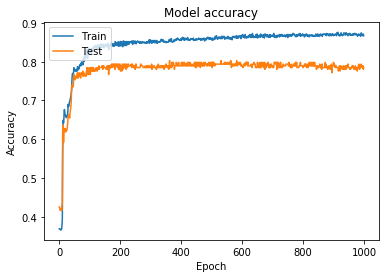

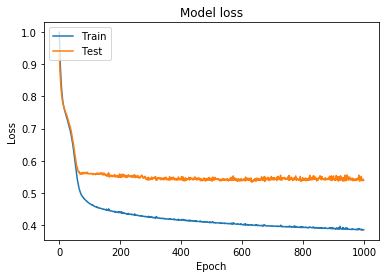

In [26]:
my_data= (X_train, y_train, X_val, y_val)
_,_,my_model=train_model(my_model,my_data,epochs=1000,learning_rate=1e-3)

## predict for test data & submit

In [27]:
y_probs=my_model.predict(X_test)
y_preds=np.rint(y_probs).astype(int)
y_preds=y_preds.reshape(-1)

In [28]:
submission = pd.DataFrame({'PassengerId':test_dataset['PassengerId'],'Survived':y_preds})


In [29]:
submission.to_csv('submission.csv',index=False)